In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os

# Replace the origin string with your specific WebSocket origin to allow use of the Phoenix dashboard
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "0klvo4n67bg2u6fr7kngsi6ip1kop1nps068mq9f8l8tfo4s604b"

import warnings

import astropy.units as u
from astropy.modeling import models
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList

from tqdm import tqdm

from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid
from muler.hpf import HPFSpectrumList
from specutils import SpectralRegion
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_derivative, fit_continuum

from scipy.signal import savgol_filter

# %config InlineBackend.figure_format='retina'

from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA
# just a pick a sequence of standards to look at: ["LkCa1","HBC427","Hubble4","Anon1","LkCa5","MHO8"])]
# Symposium sequence: ["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"]
# standard_table = standard_table[standard_table['Name'].isin(["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"])].reset_index(drop=True)

proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\protostar_table.txt', index_col=0)

standards_path = standard_table['File']
standard_list = standard_table['File'].values

proto_path = proto_table['File']
proto_list = proto_table['File'].values

In [3]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

na_reg_lines = sorted([lines_table[na1_mask][0]['Observed'],
                lines_table[sc1_mask][19]['Observed'],
                lines_table[si1_mask][2]['Observed'],
                lines_table[sc1_mask][20]['Observed'],
                lines_table[na1_mask][1]['Observed']])

na_reg_names = [lines_table[sc1_mask][19]['Spectrum'],
                lines_table[na1_mask][0]['Spectrum'],
                lines_table[si1_mask][2]['Spectrum'],
                lines_table[sc1_mask][20]['Spectrum'],
                lines_table[na1_mask][1]['Spectrum']]

na_reg_lines = np.array(na_reg_lines)

ti_reg_lines = np.array([lines_table[ti1_mask]['Observed'][44],
        lines_table[ti1_mask]['Observed'][45],
        lines_table[fe1_mask]['Observed'][85],
        lines_table[fe1_mask]['Observed'][86],
        lines_table[ti1_mask]['Observed'][47]])

ca_reg_lines = list(lines_table[ca1_mask]['Observed'][:]) # list of Ca I lab wavelengths
ca_reg_lines.append(lines_table[fe1_mask]['Observed'][104])
ca_reg_lines = np.array(sorted(ca_reg_lines))

In [4]:
wavmin = int(2.075*1e4)
wavmax = int(2.289*1e4)

# PHOENIX MODELS

In [14]:
phoenix_mod_path = "C:\\Users\\Savio\\Documents\\Research\\phoenix_models\\phoenix.astro.physik.uni-goettingen.de\\HiResFITS\\"

In [7]:
spec_list = []
for i in tqdm(range(len(standard_table))):
    spec = IGRINSSpectrumList.read(standard_table['File'][i])\
        .trim_overlap().stitch()
    spec = spec.apply_boolean_mask(mask=(np.isfinite(spec.flux.value)) & 
                                    (spec.wavelength.value > wavmin) & 
                                    (spec.wavelength.value < wavmax))

    spec_list.append(spec.normalize().remove_nans())


100%|██████████| 23/23 [00:06<00:00,  3.50it/s]


In [8]:
standard_table

,File,Name,Spectral_Type,PM_Teff
0,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,HD30171,G5,5660
1,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,HD283572,G5,5660
2,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,LkCa19,K0,5280
3,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,HBC427,K5,4450
4,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,LkCa4,K7,4050
5,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,Hubble4,K7,4050
6,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,V830Tau,K7,4050
7,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,L1551-55,K7,4050
8,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,V827Tau,K7,4050
9,C:\Users\Savio\Documents\IGRINS-Spectra\Standa...,L1551-51,K7,4050


# Use PHOENIX Dashboard to manually fit T_eff (and log g?)

In [15]:
# relatively good protostars: 4,5,7,9,10,11,12,13,15,16,17,18,21,22,24,26,27,29,31,33,34,39,42,43,46
# rough Temperature guess: 3500,4500,?,?,4000,4100,4000,
spectrum_n = 10 # index for spec_list (list of Spectrum1D objects)
teff_min, teff_max = 2300, 5500
logg_min, logg_max = 0,6

grid = PHOENIXGrid(teff_range=(teff_min, teff_max),
                   logg_range=(logg_min, logg_max),
                   Z_range=(0,0.5),
                   wl_lo=wavmin,
                   wl_hi=wavmax,
                   path=phoenix_mod_path,
                   instrumental_resolution=45000
                  )

Processing Teff=5500K|log(g)=6.00|Z=+0.5: 100%|██████████| 858/858 [00:54<00:00, 15.80it/s]


In [67]:
grid.show_dashboard(spec_list[spectrum_n])

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1599'}, 'attr': 'value', 'new': 5.000000000000001}]} 
 error: KeyError((4100, 5.000000000000001, np.float64(0.0)))
Traceback (most recent call last):
  File "c:\Users\Savio\anaconda3\envs\gollum_dev\Lib\site-packages\bokeh\server\protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Savio\anaconda3\envs\gollum_dev\Lib\site-packages\bokeh\server\session.py", line 94, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Savio\anaconda3\envs\gollum_dev\Lib\site-packages\bokeh\server\session.py", line 286, in _handle_patch
    message.apply_to_document(self.document, self)
  File "c:\Users\Savio\anaconda3\envs\gollum_dev\Lib\site-packages\bokeh\protocol\messages\patch_

# Try to fit parameters programatically

In [17]:
# min and max wavelengths for fitting to some regions
na_wv_min, na_wv_max = 2.2040*u.um, 2.2110*u.um
ti_wv_min, ti_wv_max = 2.2219*u.um, 2.2350*u.um
ca_wv_min, ca_wv_max = 2.2605*u.um, 2.2670*u.um

@np.vectorize
def chi_squared_vels(spectrum, teff_guess, logg_guess, vsini, rv, r_k, spec_res):
    '''
    spectrum = index in spec_list
    teff_guess = float, must be in steps of 100 K from 2300-7000 K, 200 K after that
    logg_guess = float, must be in steps of 0.5 from 0-6
    vsini = float
    rv = float
    
    '''
    model = PHOENIXSpectrum(teff=teff_guess,
                            logg=logg_guess,
                            Z=0,
                            wl_lo=wavmin,
                            wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).rotationally_broaden(vsini)\
                            .rv_shift(rv)\
                            .resample(spec_list[spectrum])\
                            .normalize()\
                            .instrumental_broaden(spec_res)

    # Flux and uncertainties
    veil_factor = (1+r_k)
    observed_flux = spec_list[spectrum].flux
    veil_model_flux = (model.flux + r_k) / (veil_factor)
    uncertainty = spec_list[spectrum].uncertainty.array  # Array of flux uncertainties
    
    # Compute chi-squared
    chi_squared = np.nansum((observed_flux - veil_model_flux)**2 / veil_model_flux)
    return chi_squared

In [18]:
# @np.vectorize
# def chi_squared_vels(spectrum, teff_guess, logg_guess, vsini, rv, r_k, spec_res):
#     '''
#     spectrum = index in spec_list
#     teff_guess = float, must be in steps of 100 K from 2300-7000 K, 200 K after that
#     logg_guess = float, must be in steps of 0.5 from 0-6
#     vsini = float
#     rv = float
#     '''
#     # Define wavelength regions for masking
#     mask_regions = [
#         (22050 * u.AA, 22105 * u.AA),
#         (22219 * u.AA, 22345 * u.AA),
#         (22605 * u.AA, 22665 * u.AA),
#     ]

#     # Get the observed spectrum and apply the mask
#     observed_spectrum = spec_list[spectrum]
#     wavelength = observed_spectrum.spectral_axis

#     mask = np.any([(wavelength >= wmin) & (wavelength <= wmax) for wmin, wmax in mask_regions], axis=0)
#     masked_wavelength = wavelength[mask]
#     masked_flux = observed_spectrum.flux[mask]
#     masked_uncertainty = observed_spectrum.uncertainty.array[mask]

#     # Generate the model spectrum and apply the mask
#     model = PHOENIXSpectrum(teff=teff_guess,
#                             logg=logg_guess,
#                             Z=0,
#                             wl_lo=masked_wavelength.min().value,  # Convert to unitless
#                             wl_hi=masked_wavelength.max().value,  # Convert to unitless
#                             path=phoenix_mod_path
#                             ).rotationally_broaden(vsini)\
#                             .rv_shift(rv)\
#                             .resample(observed_spectrum)\
#                             .normalize()\
#                             .instrumental_broaden(spec_res)

#     model_flux_masked = model.flux[mask]

#     # Compute chi-squared
#     veil_factor = (1 + r_k)
#     veil_model_flux = (model_flux_masked + r_k) / veil_factor
#     chi_squared = np.nansum((masked_flux - veil_model_flux) ** 2 / (masked_uncertainty ** 2))
#     return chi_squared


In [48]:
# t_guess = (np.round(standard_table['PM_Teff']/100)*100) # list of initial guesses for Temperature based on spectral type (standards)
temp_guess = 3800 # initial guess for Teff based on vibes
logg_guess = 4.0 # initial guess for log g based on vibes

vsinis = np.linspace(20, 24, 25)
rvs = np.linspace(10, 14, 25)
# try to add veiling?
veil_grid = np.linspace(0,0.35,25)

search_vsini, search_rv, search_rk = np.meshgrid(vsinis, rvs, veil_grid, indexing='ij')

# calculate the chi-squared along each grid point
vel_chi2_grid = chi_squared_vels(spectrum_n,
                             temp_guess,
                             logg_guess,
                             search_vsini,
                             search_rv,
                             search_rk,
                             45000
                             )
# find the index for the best fitting vsini and r_v
min_index = np.unravel_index(np.argmin(vel_chi2_grid), vel_chi2_grid.shape)
best_vsini = search_vsini[min_index]
best_rv = search_rv[min_index]
best_rk = search_rk[min_index]
# print(rf"$\chi^2 =$ {chi2_grid[min_index]}")
print(f"Best vsini: {best_vsini}, Best RV: {best_rv}, Best r_k: {best_rk}")

Best vsini: 22.333333333333332, Best RV: 12.333333333333332, Best r_k: 0.30624999999999997


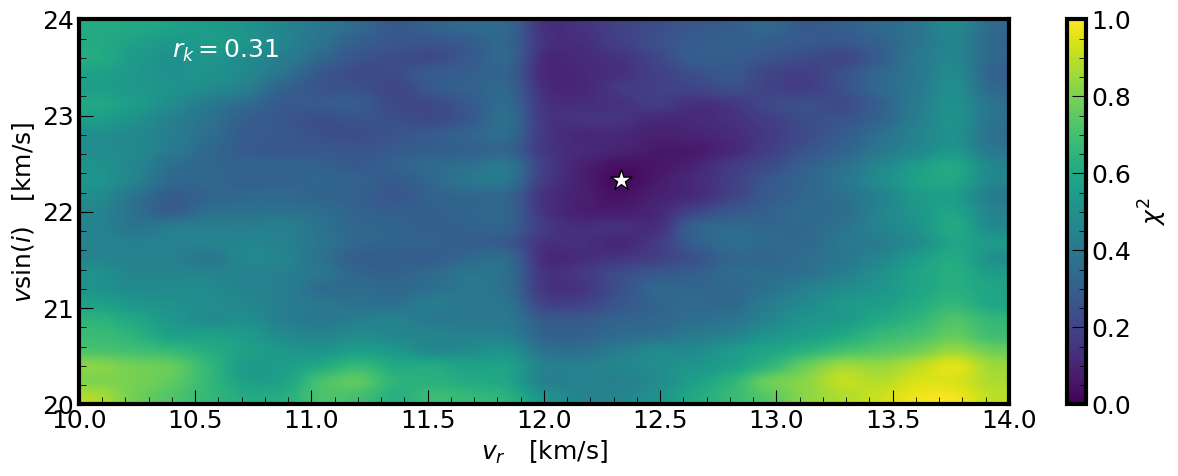

In [49]:
plt.imshow(vel_chi2_grid[:,:,min_index[2]], extent=[rvs.min(), rvs.max(), vsinis.min(), vsinis.max()],
           aspect='auto',
           origin='lower',
           interpolation='gaussian'
           )
plt.scatter(best_rv, best_vsini, marker='*', c='w', ec='k', s=250)

# Add text using fraction of axes coordinates
ax = plt.gca()  # Get current axes
ax.text(0.1, 0.9, f"$r_k = {best_rk:.2f}$", transform=ax.transAxes, c='w', fontsize=18)

plt.colorbar(label=r'$\chi^2$')
plt.xlabel(r'$v_r \quad [\mathrm{km}/\mathrm{s}]$')
plt.ylabel(r'$v\sin(i) \quad [\mathrm{km} / \mathrm{s}]$')

plt.show()

In [58]:
# best_spec = PHOENIXSpectrum(teff=temp_guess, logg=logg_guess, Z=0,
#                             wl_lo=wavmin,wl_hi=wavmax,
#                             path=phoenix_mod_path
#                             ).resample(spec_list[spectrum_n])\
#                             .tilt_to_data(spec_list[spectrum_n])\
#                             .instrumental_broaden(resolving_power=45000)\
#                             .normalize().rotationally_broaden(best_vsini).rv_shift(best_rv)
# temp_guess = 3500
# logg_guess = 3.0
best_teff = temp_guess
best_logg = logg_guess
best_spec = PHOENIXSpectrum(teff=best_teff, logg=best_logg, Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(spec_list[spectrum_n])\
                            .tilt_to_data(spec_list[spectrum_n])\
                            .rotationally_broaden(best_vsini).rv_shift(best_rv)

# veil_spec = Spectrum1D(flux=(best_spec.flux + best_rk) / (1+best_rk),spectral_axis=best_spec.wavelength)
# best_spec = veil_spec.tilt_to_data(spec_list[spectrum_n])

model_tdiff_spec = PHOENIXSpectrum(teff=best_teff+300, logg=best_logg, Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(spec_list[spectrum_n])\
                            .tilt_to_data(spec_list[spectrum_n])\
                            .rotationally_broaden(best_vsini).rv_shift(best_rv)

model_gdiff_spec = PHOENIXSpectrum(teff=best_teff, logg=best_logg+0.5, Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(spec_list[spectrum_n])\
                            .tilt_to_data(spec_list[spectrum_n])\
                            .rotationally_broaden(best_vsini).rv_shift(best_rv)

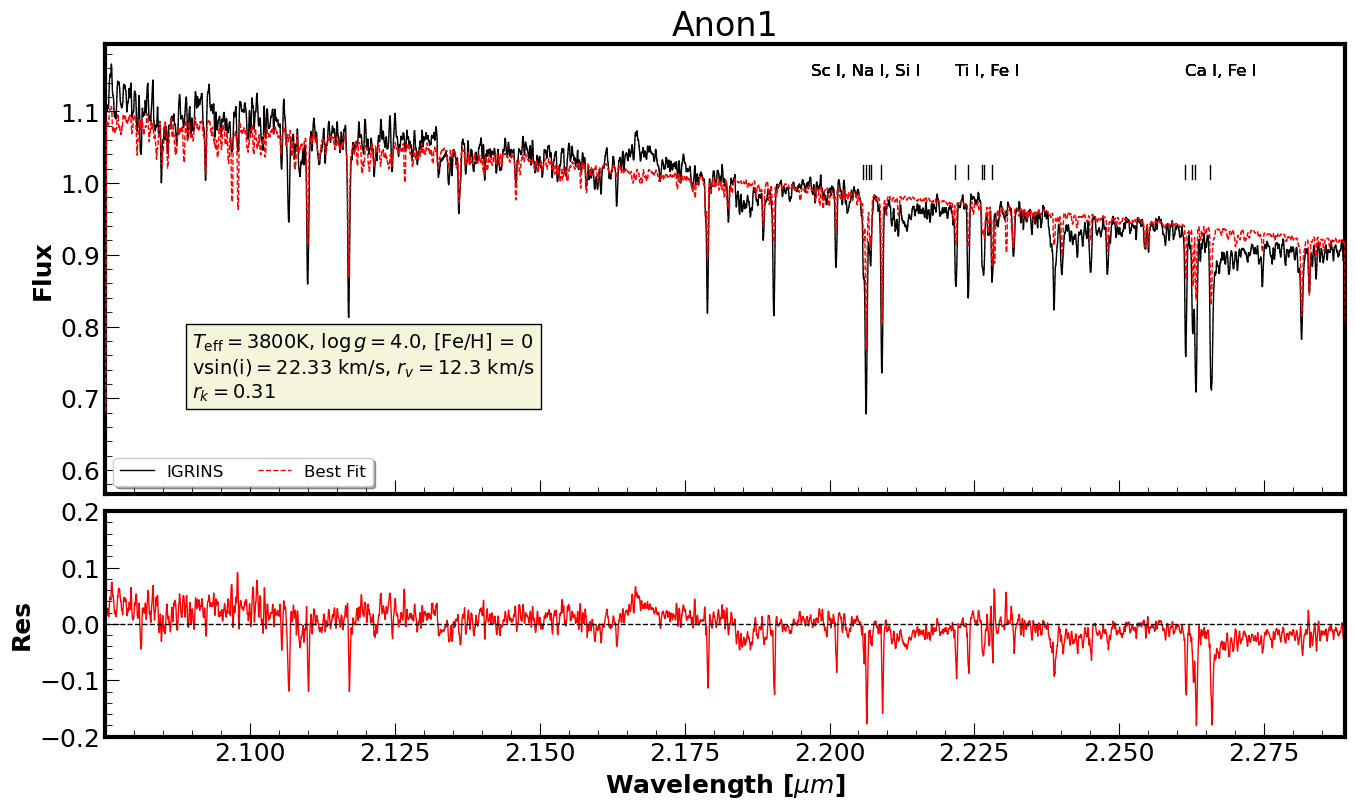

In [68]:
# smooth protostar spectrum to remove spikes
smoothed_flux = savgol_filter(spec_list[spectrum_n].flux.value , window_length=21, polyorder=3)

# veiled model flux
veil_flux = (best_spec.flux + best_rk) / (1+best_rk)
# Compute residuals: observed flux - model flux
residuals = smoothed_flux - veil_flux

from matplotlib.gridspec import GridSpec

# Set up a figure with two panels (one for spectrum, one for residuals)
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)  # GridSpec for proportional heights

ax0 = fig.add_subplot(gs[0])
ax0.step(spec_list[spectrum_n].wavelength*1e-4, smoothed_flux, # spec_list[spectrum_n].flux
         lw=1,color='k',label=rf"IGRINS",zorder=1, # $\pm 3 \sigma$
         )

ax0.step(best_spec.wavelength*1e-4, veil_flux, # best_spec.flux
        lw=1, ls='--', color='r', label='Best Fit', zorder=5
        )

# ax0.plot(model_tdiff_spec.wavelength*1e-4, model_tdiff_spec.flux,
#          lw=1, ls='-.', color='g', label=r'Best Fit$\plus 300$ K', zorder=4
#         )
# ax0.plot(model_gdiff_spec.wavelength*1e-4, model_gdiff_spec.flux,
#          lw=1, ls=':', color='b', label=r'Best Fit$\plus 0.5 \, \log g$', zorder=3
#         )
         

# Add text for parameters
ax0.text(2.09, 0.7, rf'$T_{{\rm eff}}=${best_teff:.0f}K, $\log g =${best_logg}, [Fe/H] = 0' '\n' 
         rf'$\rm v\sin(\rm i)=${best_vsini:.2f} km/s, $r_v=${best_rv:.1f} km/s' '\n'
         rf'$r_k=${best_rk:.2f}',
         color='black', bbox=dict(facecolor='beige', edgecolor='black', boxstyle='square,pad=0.3'),
         fontsize=14
         )


# Label Features
# ax0.text(2.16,1.55,r'$\rm Br\gamma$', fontsize=12) # Br-Gamma
# ax0.text(2.123,1.2,r'$\rm H_2$', fontsize=12) # H2
# ax0.text(2.225,1.3,r'$\rm H_2$', fontsize=12) # H2

for i in range(len(na_reg_lines)):
    ax0.axvline(na_reg_lines[i], ymin=0.70, ymax=0.73, ls='-', color='black', lw=1)
    ax0.text(na_reg_lines[0]-0.009, 1.15, f'Sc I, Na I, Si I', rotation=0, color='black', fontsize=12)

for i in range(len(ti_reg_lines)):
    ax0.axvline(ti_reg_lines[i], ymin=0.70, ymax=0.73, ls='-', color='black', lw=1)
    ax0.text(ti_reg_lines[0]-0.0001, 1.15, f'Ti I, Fe I', rotation=0, color='black', fontsize=12)

for i in range(len(ca_reg_lines)):
    ax0.axvline(ca_reg_lines[i], ymin=0.70, ymax=0.73, ls='-', color='black', lw=1)
    ax0.text(ca_reg_lines[0]-0.00011, 1.15, f'Ca I, Fe I', rotation=0, color='black', fontsize=12)

ax0.set_xlim(np.min(spec_list[spectrum_n].wavelength.value)*1e-4 , np.max(spec_list[spectrum_n].wavelength.value)*1e-4)
# ax0.set_xlim(2.2,2.23)
# ax0.set_ylim(bottom=0.6)
ax0.set_ylabel('Flux')
# Title and legend
ax0.set_title(f"{standard_table['Name'][spectrum_n].replace('_', ' ')}")
# legend with each set of data in one row
ax0.legend(fontsize=12, frameon=True, shadow=True, loc='best', ncol=4)

# Remove x-axis ticks for upper plot (shared axis with residuals)
ax0.tick_params(axis='x', labelbottom=False)  # Hides x-tick labels for the top panel only

# ---- Lower Panel: Residuals ----
ax1 = fig.add_subplot(gs[1], sharex=ax0)  # Share x-axis with the spectrum plot
ax1.plot(spec_list[spectrum_n].wavelength*1e-4, residuals, lw=1, color='r', label='Residuals')
ax1.axhline(0, color='k', linestyle='--', lw=1)  # Add horizontal line at zero for reference

ax1.set_ylim(-.2,.2)
# Labels for residuals plot
ax1.set_xlabel('Wavelength [$\mu m$]')
ax1.set_ylabel('Res')

# ax0.set_xlim(na_wv_min.value, ca_wv_max.value)
# Tight layout and show plot
# plt.tight_layout()
plt.show()

In [69]:
grid.show_dashboard(spec_list[spectrum_n])